# Imports

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

# Utils

In [0]:
def visualize_clusters(feat, labels, epoch):
    '''Visualise clusters
    '''
    print(f"Visualising clusters after epoch #{epoch+1}")

    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    f = plt.figure(figsize=(6,6))

    for j in range(10):
        plt.plot(feat[labels==j, 0].flatten(),
                 feat[labels==j, 1].flatten(),
                 '.', c=c[j], alpha=0.8)

    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    
    plt.show()

    plt.savefig('epoch_%d.jpg' % (epoch + 1))



def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 0.5
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()


def euclidean_distance(vects):
    x, y = vects

    return tf.sqrt(tf.keras.backend.sum(tf.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]

            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]

            labels += [1, 0]

    return np.array(pairs), np.array(labels)


# Model

In [0]:
def network(input_shape=None):
    """Siamese network model
    """
    model = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(32, (7, 7), input_shape=input_shape,
                                                        activation='relu', padding='same',
                                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()),
                                 tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

                                 tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same',
                                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()),
                                 tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

                                 tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()),
                                 tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

                                 tf.keras.layers.Conv2D(256, (1, 1), activation='relu', padding='same',
                                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()),
                                 tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

                                 tf.keras.layers.Conv2D(2, (1, 1), activation=None, padding='same',
                                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()),
                                 tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

                                 tf.keras.layers.Flatten()
                                 ])

    return model

# Train

Epoch 1/10
108400/108400 [==============================] - 21s 196us/step - loss: 0.0507 - acc: 0.4213
Visualising clusters after epoch #1


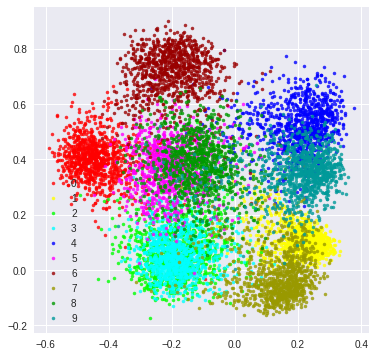

Epoch 2/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0223 - acc: 0.2799
Visualising clusters after epoch #2


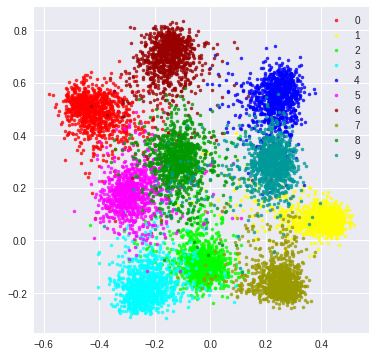

Epoch 3/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0164 - acc: 0.2318
Visualising clusters after epoch #3


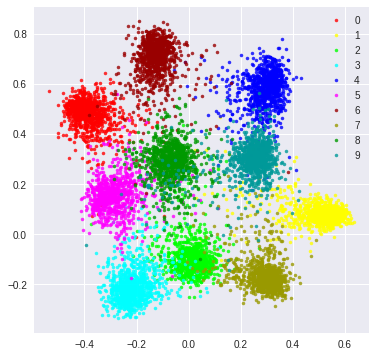

Epoch 4/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0138 - acc: 0.2099
Visualising clusters after epoch #4


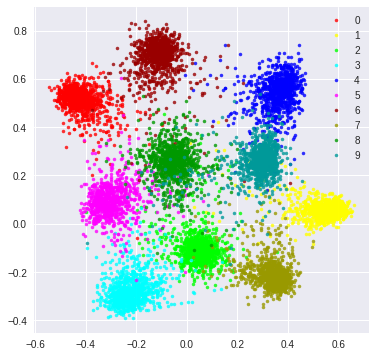

Epoch 5/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0122 - acc: 0.1980
Visualising clusters after epoch #5


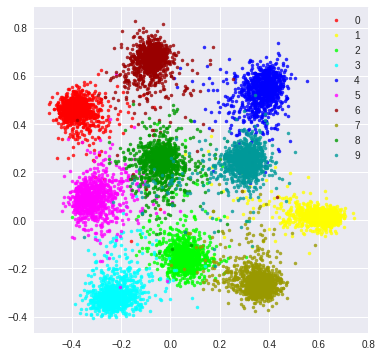

Epoch 6/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0110 - acc: 0.1898
Visualising clusters after epoch #6


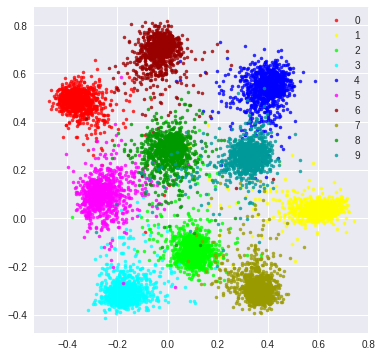

Epoch 7/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0102 - acc: 0.1834
Visualising clusters after epoch #7


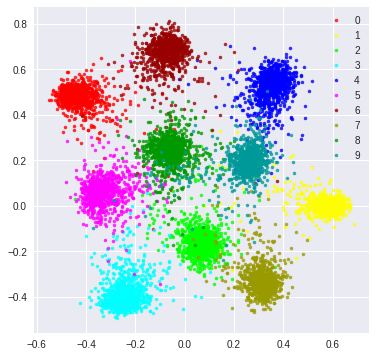

Epoch 8/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0093 - acc: 0.1769
Visualising clusters after epoch #8


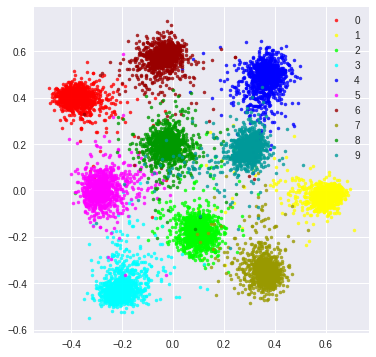

Epoch 9/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0088 - acc: 0.1724
Visualising clusters after epoch #9


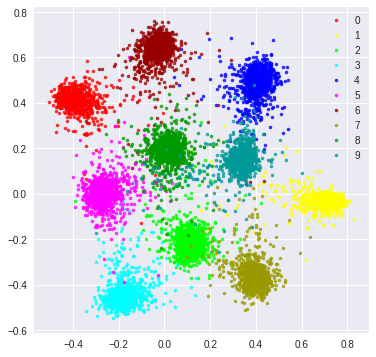

Epoch 10/10
108400/108400 [==============================] - 16s 145us/step - loss: 0.0081 - acc: 0.1679
Visualising clusters after epoch #10


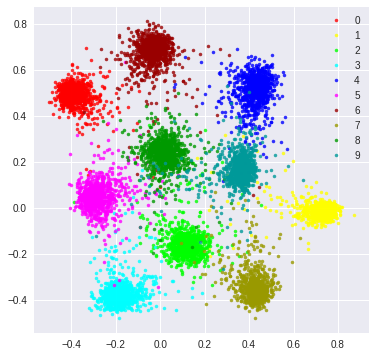

* Accuracy on test set: 75.0783%


In [4]:
# hyperparameters

lr = 1e-3
beta1, beta2 = 0.9, 0.999
epochs = 10
batch_size = 4096


# dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

x_train, x_test = x_train/255, x_test/255
input_dim = (28, 28, 1)


digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(x_test, digit_indices)


# model

base_network = network(input_shape=input_dim)

input_a = tf.keras.layers.Input(shape=(*input_dim,))
input_b = tf.keras.layers.Input(shape=(*input_dim,))

feat_a = base_network(input_a)
feat_b = base_network(input_b)

distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_a, feat_b])

mnist_model = tf.keras.Model(inputs=[input_a, input_b], outputs=[distance])

optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2)
metrics = ['accuracy']

mnist_model.compile(loss=contrastive_loss, optimizer=optim, metrics=metrics)


# train
visualize_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,
                                                       logs: visualize_clusters(base_network.predict(x_test),
                                                                                y_test, epoch))

mnist_model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[visualize_callback])


# test

pred = mnist_model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on test set: %0.4f%%' % (100 * te_acc))